In here I am going to attempt to build a Neural_Network class from scratch and test it on both simple multi-class classification problem.

In essense, this neural network operates by iterating over forward propagation, backpropagation and gradient descent for a stated number of time.

During forward propagation, sigmoid function is used as the activation function to compute the inputs for the next layer until for the final hidden layer, softmax function is used as the activation function to compute the output. 
Please see the below diagram for a better illustration of the forward propagation process. Note that the bias units is set to have a fixed value of 1 and this will not change as the bias units doesn't have any inputs.

The inital values for the weight θ(i) are randomly selected from the uniform distribution with the range:
$$\left(-1/\sqrt{d_i}, 1/\sqrt{d_i}\right)$$
where d is the number of neuron node in layer i.

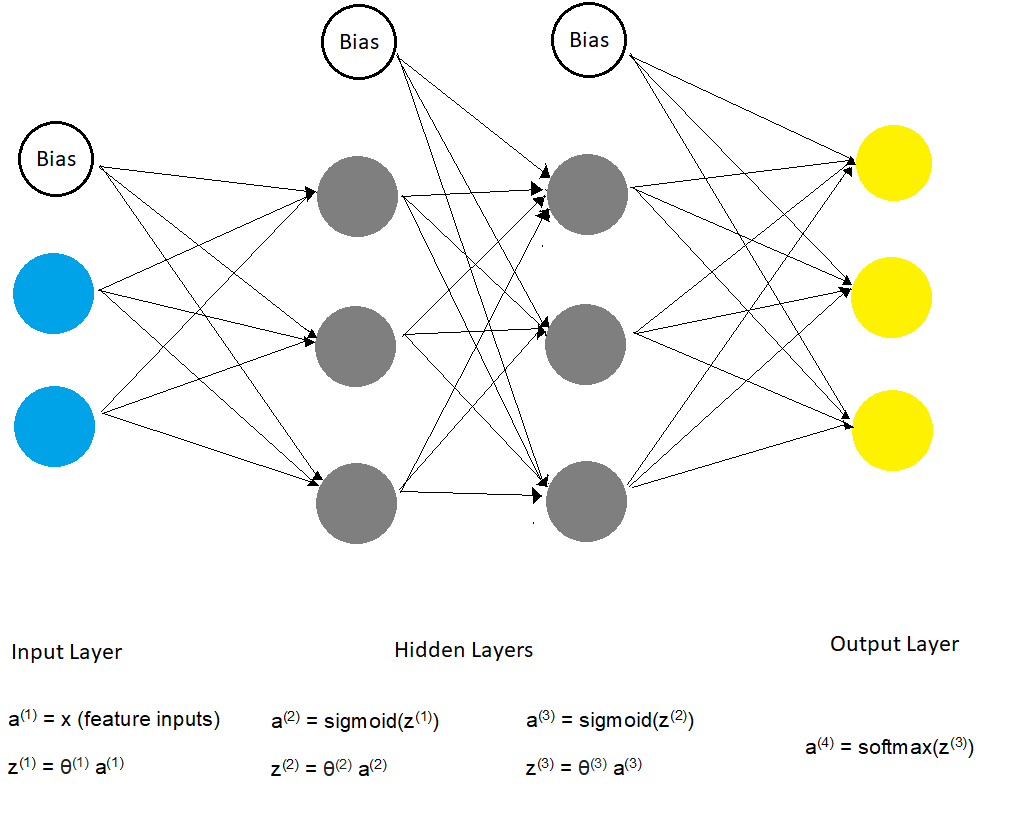

In [69]:
from IPython.display import Image, display
display(Image(filename='images\\NN_FP.png', embed=True))

Backward propagation is performed to compute the gradient of the cost function with respect to each weight. Since we have a softmax output, the loss function is defined as the cross-entropy loss:

$$E = 1/N\sum_{n = 1}^N\sum_{i = 1}^Cy_{n,i}log\hat{y}_{n,i} $$

During backpropagation, the term delta is calculated for each layer which is then used to calculate the gradient of L with respect to the weight in the previous layer. This process starts from the outer layer and propagate all the way back to the input layer (hence the term backpropagation). Namely,
$$ \Delta E/\Delta \theta_{ℓ}=  \delta_{ℓ+1} * a_{ℓ}$$
where ℓ indicate the layer.




------------remove----------------------------------------------------

Starting from the outer layer, the gradient of the last hidden layer is simply:
$$ \Delta E/\Delta \theta_{i,o}=  (\hat{y}_o - y_o) * a_{i}$$

with the term: $$ (\hat{y}_o - y_o)$$ as the delta term. Where o refer to the output layer and i refer to the last hidden layer. 

Without going into a lot of the details of the maths that goes behind it, it can be essentially derived by using chain-rule:
$$\Delta E / \theta_{i,o} = \Delta E/ \Delta y_o \times \Delta y_o/ \Delta z_i \times \Delta z_i/ \Delta \theta_{i,o}$$
where each of the partial derivative can be derived by considering that:
$$E = - \sum_i^Ny_olog(\hat{y}_o)$$
$$y_o = e^{z_i}/({\sum_{c = 1}^Ce^{z_c}})$$
------------remove----------------------------------------------------







In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
import itertools
import logging

class Neural_network():
    def __init__(self, X = np.array, y = np.array, hidden_layer_size  = tuple, alpha = float, num_iter = int, lamb = float):
        self.X = X
        # each element in y needs to be converted into the representative vector to allow computation
        self.y_class = y
        self.unique_class = np.unique(y).tolist()
        #dataset is a numpy array with both the X and y (class representation) axis.
        self.dataset = np.concatenate((self.X, self.y_class.reshape(-1,1)), axis = 1)
        # convert the label into vector representation
        self.y = self.label_convert(y)            
        self.alpha = alpha
        self.num_iter = num_iter
        self.num_layer = len(hidden_layer_size) + 2
        # initialise the weight matrix here
        # the weight matrix of each layer is stored as elements inside a list
        # there should be (len(whole_network_size) - 1) number of weight matx
        self.weights = []

        self.number_of_output = np.unique(y).size
        self.whole_network_size = (X.shape[1],) + hidden_layer_size + (self.number_of_output,)
        for i in range(len(self.whole_network_size) - 1):
            ### initial weight shouldn't be zero
            d = self.whole_network_size[i] + 1 # +1 to account for bias unit
            limit = np.sqrt(1/d)
            # the weight is a N x M matrix, where N is number of unit in the next layer, and M is the number of unit of \ 
            # current layer + 1 bias unit
            weight = np.random.uniform(-limit, limit, (self.whole_network_size[i+1], self.whole_network_size[i] + 1))
 #           weight = np.zeros()
            self.weights.append(weight)
        self.lamb = lamb
        self.M = self.X.shape[0]
        
    def sigmoid(self, z = np.array):
        h = 1/(1+np.exp(-z))
        return h
    def softmax(self, z = np.array):
        #compute softmax of z (z is an N x M array, where N is the number of features and M is the number of training examples)
        h = np.exp(z)/np.sum(np.exp(z), axis = 0)
        return h
    def forward_propagation(self, x = np.array):
        # this is perform on one training example each time, and return the output as vector
        # for now only use sigmoid function for activation hiddent and input layer
        # forward propagation compute the sigmoid output of the dot product of Wi and ai up to the second last layer.
        # the output of that would be the next layer input 
        # current_input is a N x M matrix, where N is the number of features and M is the number of examples
        # the input (a) of each layer is stored in a list as vectors and has the structure of input layer + hidden layer

        inputs = []
 #       print (x)
        # start off with the features (X) as the first layer input (with bias unit). Input can always be expressed as a vector
        current_input = np.concatenate((np.ones((x.shape[0], 1)), x), axis = 1).T.astype(np.float64)
  #      current_input = np.insert(x, 0, 1.0).astype(np.float64).reshape(-1,1)
        if current_input.shape != (x.shape[1]+1,x.shape[0]):
            logging.warning("initial current_input shape is " + str(current_input.shape) + " when it is supposed to be " + str((x.shape[1]+1,x.shape[0])))
            
  #      current_input = np.concatenate(np.ones(x.shape), x).T
        inputs.append(current_input)
        for i in range(len(self.whole_network_size) -2):
            z = np.dot(self.weights[i], current_input)
            if z.shape != (self.whole_network_size[i+1], x.shape[0]):
                logging.warning("z shape is " + str(z.shape) + " when it is supposed to be " + str((self.whole_network_size[i+1], x.shape[0])))
            h = self.sigmoid(z)
            #add a bias unit to each training example
            current_input = np.concatenate((np.ones((1, x.shape[0])), h), axis = 0).astype(np.float64)
       #     current_input = np.insert(h, 0, 1.0).astype(np.float64).reshape(-1,1)
            if current_input.shape != (self.whole_network_size[i+1] + 1,x.shape[0]):
                logging.warning("current_input shape is " + str(current_input.shape) + " when it is supposed to be " + str((self.whole_network_size[i+1] + 1,x.shape[0])))
            inputs.append(current_input)
        #use softmax for final layer to compute the output, current input is now the input of the final hidden layer
        z = np.dot(self.weights[-1], current_input)
        if z.shape != (self.whole_network_size[-1], x.shape[0]):
            logging.warning("final z shape is " + str(z.shape))
            
        #output has the shape N x M, where N is the features and M is the number of training example
            
        output = self.softmax(z)  
        
        
        return (inputs, output)
    def backward_propagation(self, inputs = list, output = np.array, y_label = np.array):
        # deltas is a list of vectors with shape identical to the corresponding neuron node of each layers 
        # gradients is a list of matrices of the gradient of cost functions. such list and matrices should have the \
        # same shape as the list weights
        # back prop is performed on 1 training example each time (stochastic)
        global gradients
        global deltas
        deltas = []
        gradients = []

        #compute the delta value of the last layer (output layer) first then propagate backward with loop
        delta = (output - y_label).reshape(-1,1)
        if delta.shape != output.shape:
            logging.warning("initial delta shape is " + str(delta.shape))            
        deltas.append(delta)       
        gradient = np.dot(delta, inputs[-1].T)
        gradients.insert(0, gradient)
        delta = np.dot(self.weights[-1].T, delta) * inputs[-1] * (1 - inputs[-1])
        delta = np.delete(delta, 0, axis = 0)
        deltas.insert(0, delta)        

        # working backward from the second last hidden layer, the gradient is computed and stored.
        # the delta value of such layer is then computed and stored
        # for the last layer (input), there's no regularisation term
        for i in range(len(self.whole_network_size)-3, -1, -1):
      #      print (i)
            if i == 0:
                lamb = 0
            else:
                lamb = self.lamb
                
            # if gradient return a single number, it's wrong. Should be the same shape as weight.
            if i == len(self.whole_network_size)-2:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
            else:
                if delta.shape != (self.weights[i].shape[0], 1):
                    logging.warning(str(i) +" delta shape is" + str(delta.shape) + " when it is supposed to be " + str((self.weights[i].shape[0], 1)))
                
            if inputs[i].T.shape != (1, self.weights[i].shape[1]):
                logging.warning("input shape is" + str(inputs[i].T.shape))
                
            gradient = np.dot(delta, inputs[i].T)  + (self.lamb/ self.M) * self.weights[i]
#             if gradient.shape != (self.weights[i].shape:
#                 logging.warning("gradient shape is" + str(gradient.shape)  when it should be )
                
            gradients.insert(0, gradient)
            
            delta = np.dot(self.weights[i].T, delta) * inputs[i] * (1 - inputs[i])
            delta = np.delete(delta, 0, axis = 0)
            deltas.insert(0, delta)
#            print (deltas)
        # check if shape of gradients is the same as weights
        for i in range(len(gradients)):
            if gradients[i].shape != self.weights[i].shape:
                logging.warning("gradient shape is" + str(gradient.shape))
        return gradients

    def gradient_descent(self, gradients = list):
        #gradients should have the exact same structure as weights (list of matrices)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] - self.alpha * gradients[i] # regularisation term already taken into account during back prop
    def label_convert(self, y):
        converted_output = []
        for label in y:
            output_vector = np.zeros(np.unique(y).size)
            index_num = self.unique_class.index(label)
            output_vector[index_num] = 1
            converted_output.append(output_vector)
        return np.array(converted_output)    
        
        
    def fit(self):
        global inputs
        losses = {}
        step = 0
        np.random.shuffle(self.dataset)
        X_shuffled, y_shuffled = np.hsplit(self.dataset, [self.dataset.shape[1]- 1,])
        y_shuffled = self.label_convert(y_shuffled)  
        for index in itertools.cycle(range(X_shuffled.shape[0])):
            x = X_shuffled[index].reshape(1,-1)
            inputs, output = self.forward_propagation(x)
            
            #compute the loss function here before gradient descent for every 10 iteration
            if step %10 == 0:
                _, outputs = self.forward_propagation(X_shuffled)
                loss = (-1/y_shuffled.shape[0]) * np.sum(y_shuffled * np.log(outputs.T))
                losses[step] = loss
            
            #update the weight
            gradients = self.backward_propagation (inputs = inputs, output = output, y_label = y_shuffled[index].reshape(-1,1))
            self.gradient_descent(gradients = gradients)    
            step += 1
            
            #if number of iteration specified met, stop optimising.
            if step > self.num_iter:
                break
        
        return (losses)
    def predict(self, X_test = np.array):
        global outputs
        global class_output
        class_output = []
        #convert the vector into the corresponding class with the highest score,
        inputs, outputs = self.forward_propagation(X_test)
        outputs[outputs == np.max(outputs, axis = 0)] = 1
        outputs[outputs != np.max(outputs, axis = 0)] = 0
        for output in outputs.T.tolist():
            index_num = output.index(1)
            clas = self.unique_class[index_num]
            class_output.append(clas)

        return np.array(class_output)

    def score(self, X_test = np.array, y_test = np.array):
        #compare the output to the actual label and work out the accuracy ratio.
        predicted_outputs = self.predict(X_test)
        accu = (predicted_outputs == y_test).sum()/len(predicted_outputs)
        return accu          

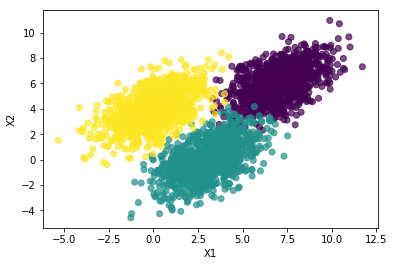

In [75]:
np.random.seed(10)
A = np.random.multivariate_normal([7, 6], [[2, 1],[1, 2]], 1000)
B = np.random.multivariate_normal([3, 0], [[2, 1],[1, 2]], 1000)
C = np.random.multivariate_normal([0, 4], [[2, 1],[1, 2]], 1000)
X = np.concatenate((A, B, C))
y = np.concatenate((np.array(["A" for i in range(A.shape[0])]), 
                    np.array(["B" for i in range(B.shape[0])]), 
                    np.array(["C" for i in range(C.shape[0])])))
cm = y.copy()
cm[cm == "A"] = 1
cm[cm == "B"] =2
cm[cm =="C"] =3
plt.figure()
plt.scatter(np.array([i[0] for i in X]), np.array([i[1] for i in X]), c = cm, alpha = 0.7)
#plt.scatter(*np.hsplit(X, 2), c = y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)


In [139]:
C = Neural_network(X_train, y_train, hidden_layer_size = (100,), alpha = 0.03, num_iter = 500, lamb = 0)
losses = C.fit()
C.score(X_test, y_test)

0.98333333333333328

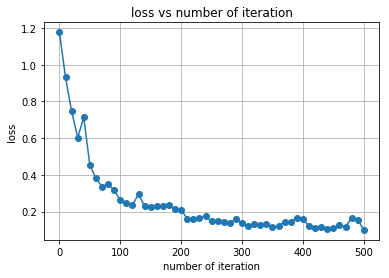

In [140]:
plt.figure()
plt.title("loss vs number of iteration")
plt.ylabel("loss")
plt.xlabel("number of iteration")
plt.grid()
plt.plot(list(losses.keys()), list(losses.values()), marker = "o")

In [100]:
mlp = MLPClassifier(hidden_layer_sizes = (100,), activation = "logistic", solver = "sgd", max_iter=200,alpha=0.01, shuffle = True, learning_rate = "constant")
mlp = mlp.fit(X_train,y_train)
mlp.score(X_test, y_test)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.98166666666666669

In [102]:
mlp.coefs_

[array([[ -3.44623644e-01,   6.58606970e-02,  -3.22282445e-02,
           1.68386661e-01,   3.51152983e-01,   8.77520054e-02,
          -2.97284297e-02,  -2.21885338e-01,   7.80667794e-02,
           3.01862599e-01,   2.71016403e-01,  -4.70180422e-02,
          -7.14832816e-02,   2.17862417e-01,   2.26391983e-01,
          -1.42477290e-01,  -1.49575687e-02,  -4.19324094e-01,
          -1.32320274e-01,  -1.25972015e-02,  -3.78594692e-02,
           7.86130571e-02,  -1.66877796e-01,  -1.63414798e-03,
          -1.67558996e-01,   1.93868549e-01,   2.91009797e-01,
           8.03258956e-02,  -1.50050165e-02,  -3.58219277e-01,
          -4.16132913e-02,   1.75812691e-01,  -1.91182422e-01,
          -2.20776757e-02,  -4.01727652e-01,   7.29921828e-02,
           1.67970481e-02,  -3.46174491e-01,   1.66802102e-01,
          -4.25713816e-01,  -1.14568531e-01,  -3.09886869e-01,
           2.43271984e-01,   2.70206359e-01,  -7.97542167e-02,
          -4.76057023e-01,  -3.22847091e-01,   1.271750

In [103]:
C.weights

[array([[  5.14264085e-01,  -5.02303943e-01,   1.13284898e-01],
        [ -3.56997125e-01,  -4.09086514e-01,   1.46440663e-01],
        [  2.08126270e-03,   3.84464160e-01,   3.34753202e-01],
        [  4.88461595e-01,  -4.34858610e-01,   4.15517374e-01],
        [ -5.85263246e-01,   1.28799629e-01,   3.30238611e-01],
        [  5.36012575e-01,   1.19792766e-01,  -2.94027481e-01],
        [ -7.01950469e-02,   2.35146058e-01,   1.77098856e-01],
        [  4.43977101e-01,   1.07699441e-02,   3.58426088e-01],
        [ -6.87077648e-03,   1.48967925e-02,  -3.68061565e-01],
        [ -3.64410990e-01,  -9.06475399e-02,   3.20280926e-01],
        [ -2.98841798e-01,   2.16436939e-01,  -5.92621243e-01],
        [  1.14191190e-01,  -3.80330194e-01,  -5.31832800e-01],
        [ -5.12363364e-01,   3.97029234e-02,   3.30379001e-01],
        [  2.97245862e-01,   2.67637871e-01,  -6.35831069e-01],
        [  2.60859623e-01,  -1.47760016e-01,  -1.19851064e-01],
        [ -4.81967314e-01,  -5.62638274e